In [9]:
import sys 
import os 
from glob import glob 
import os.path as osp
import numpy as np 
import torch as th 
import random
from torch.utils.data import DataLoader
import matplotlib
from matplotlib import pyplot as plt 
matplotlib.use('TkAgg')
%matplotlib inline


sys.path.append("../src")
from depth_model.model import PTModel
from utils.load_tof_images import create_from_zip_absolute  as load_assignment_data
from data_loader.data_loader_assignment import CreateAssignemntDataset
from utils.data_transforms import pre_process
from depth_model import inference as infer


print(th.cuda.is_available())
device = 'cuda' if th.cuda.is_available() else 'cpu'

model_checkpoint = "../model/child_depth_model.ckpt"

path = "../data/360_scan/"
child_rgb_files = glob(path+"/*/rgb/*")
child_depth_files = glob(path+'/*/depth/*')
print("Total number of imgaes :",len(child_rgb_files))

True


Total number of imgaes : 255


### Predict and Visualize 

#### Functions 

In [2]:
def to_multichannel(i):
    if i.shape[2] == 3: return i
    i = i[:,:,0]
    return np.stack((i,i,i), axis=2)

def tensor_to_numpy_image(image,rgb=True):
    image = image.permute(1,0,2,3).squeeze(axis=0).cpu().detach().numpy()
    if rgb:
        image = image.squeeze(axis=1)
        return np.array(image.transpose(1, 2, 0)*255, dtype=np.uint8) 
    else:
        return image.squeeze(axis=0)

def DepthNorm(x, maxDepth):
    return maxDepth / x

### Load Model

In [3]:
depth_model = PTModel().float().to(device)
checkpoint = th.load(model_checkpoint)
depth_model.load_state_dict(checkpoint)

/home/samartht/anaconda3/envs/pydepth/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/samartht/anaconda3/envs/pydepth/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


<All keys matched successfully>

torch.Size([3, 640, 480])
torch.Size([1, 320, 240])


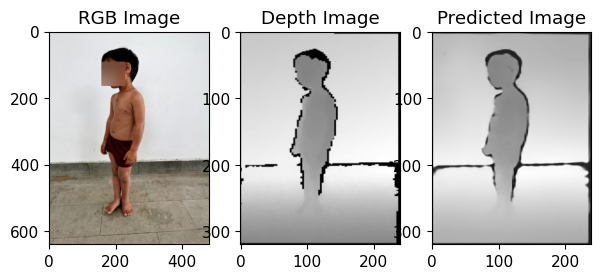

In [10]:
data_loader = CreateAssignemntDataset(child_rgb_files,child_depth_files,process_image=pre_process())
train_loader = DataLoader(data_loader, batch_size= 1, shuffle=True, num_workers=1)

random_idx = random.randint(0, len(data_loader)-1)
sample = data_loader[random_idx]

print(sample['image'].shape)
print(sample['depth'].shape)

plt.figure(figsize=(7,15))

for i, sample_batch in enumerate(train_loader):
    image = sample_batch['image'].to(device)
    depth = sample_batch['depth'].to(device)
    
    y_pred = depth_model(sample_batch['image'].to(device))
    y_pred = tensor_to_numpy_image(y_pred,rgb=False)
    depth_image = tensor_to_numpy_image(depth,rgb=False)
    resize_image =  tensor_to_numpy_image(image) # , shape, preserve_range=True, mode='reflect', anti_aliasing=True )
    
    plt.subplot(1,3,1)
    plt.title("RGB Image")
    plt.imshow(resize_image)

    plt.subplot(1,3,2)
    plt.title("Depth Image")
    plt.imshow(depth_image,cmap='gray')

    plt.subplot(1,3,3)
    plt.title("Predicted Image")
    plt.imshow(y_pred,cmap='gray') 


    # print(f"Image resolution: {y_pred.shape}")
    # print(f"Data type: {y_pred.dtype}")
    # print(f"Min value: {np.min(y_pred)}")
    # print(f"Max value: {np.max(y_pred)}")
    if i == 4:
        break
    

### Fine Tune  with Assignment Dataset

In [ ]:
# save layer names
layer_names = []
for idx, (name, param) in enumerate(depth_model.named_parameters()):
    layer_names.append(name)
# Getting the depth layers for decoder 
# reverse layers
layer_names.reverse()
print(layer_names[0:20])
            

### Retrain the Model with Dataset provided by the Assignement with some changes 

## Fine Tune with LR 
The key idea is to gradually reduce the learning rate when going deeper into the network. The first layers should already have a pretty good understanding of general domain-agnostic patterns after pre-training. In a computer vision setting, the first layers may have learned to distinguish simple shapes and edges; in natural language processing, the first layers may be responsible for general word relationships. We don't want to update parameters on the first layers too much, so it makes sense to reduce the corresponding learning rates. In contrast, we would like to set a higher learning rate for the final layers, especially for the fully-connected classifier part of the network. Those layers usually focus on domain-specific information and need to be trained on new data.

### Fine Tune with Augmetations 
Adding Augmentations to generalize the Brightness and contrast in the image , though the environment seems restricted , but still it is a good practice to add randomize brightness and contrast. Adding Rotations and Gaussian blur is another augmentation technique that helped to improve the loss.

In [ ]:
import albumentations as album

def fine_tune(pretrined_model):
    # save layer names
    layer_names = []
    for idx, (name, param) in enumerate(pretrined_model.named_parameters()):
        layer_names.append(name)
    # Getting the depth layers for decoder 
    # reverse layers
    layer_names.reverse()

    # learning rate
    lr      = 1e-2
    lr_mult = 0.9
    # placeholder
    parameters = []

    # store params & learning rates
    for idx, name in enumerate(layer_names):
        # append layer parameters
        parameters += [{'params': [p for n, p in pretrined_model.named_parameters() if n == name and p.requires_grad],
                        'lr':     lr}]
        # update learning rate
        lr *= lr_mult
    return parameters

def get_training_augmentation():
    train_transform = [
        album.OneOf(
            [
                album.RandomBrightnessContrast(p=1),
                album.ChannelShuffle(p=1),
                album.Sharpen(p=1),
                album.SafeRotate(p=1)
            ],
            p=0.75,
        ),
    ]
    return album.Compose(train_transform)

fine_tune = False
if fine_tune :
    checkpoint = th.load("../model/depth_model.ckpt") 
    depth_model.load_state_dict(checkpoint)
    parameters  = fine_tune(pretrined_model=depth_model)
    print(th.optim.Adam(parameters))

## Run the train pipeline thereafter 

# Run the train.py with --pretrained argument from terminal 
# os.system("python train_assignment_data.py --path ../Data/Assignment_data/360_scans --pretrained ../model/child_depth_model.ckpt --model_name child_depth_model --outdir /content/model --epochs 40 ")

### Run Inference on Assignment images 

In [5]:
rgb_fpath = child_rgb_files[np.random.randint(0,255)]
depth_fpath = rgb_fpath.replace('rgb','depth')
calib_fpath = os.path.dirname(rgb_fpath).replace('rgb','calibration/0')

data = load_assignment_data(rgb_fpath=rgb_fpath,depthmap_fpath=depth_fpath,calibration_fpath=calib_fpath)

### Using Inference Funstion from src/model to Infer images 

In [12]:
import cv2 
predicted_image  = infer.inference_rgbimage(data[8],depth_scale=data[4],depth_image_size=(640,480))

Could not find image processor class in the image processor config or the model config. Loading based on pattern matching with the model's feature extractor configuration.


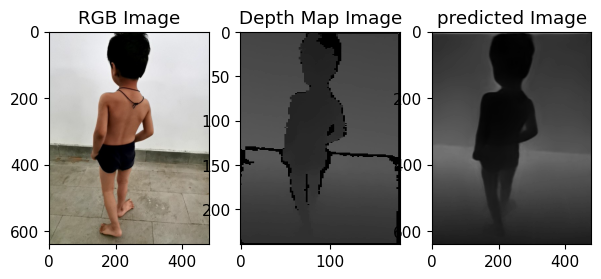

In [13]:
plt.figure(figsize=(7,15))
plt.subplot(1,3,1)
plt.title("RGB Image")
plt.imshow(data[8])

plt.subplot(1,3,2)
plt.title("Depth Map Image")
plt.imshow(np.asarray(data[3],dtype=np.float32),cmap='gray')

plt.subplot(1,3,3)
plt.title("predicted Image")
plt.imshow(predicted_image,cmap='gray')
plt.show()